In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from cryptography.fernet import Fernet
from dotenv import load_dotenv
import os
from io import BytesIO
import seaborn as sns

load_dotenv()

True

In [2]:
# open the matrices

key = os.getenv("ENCRYPTION_KEY")
fernet = Fernet(key.encode())
encrypted_matrices = pickle.load(open("DATA/encrypted_matrices.p", "rb"))
matrices = pickle.loads(fernet.decrypt(encrypted_matrices))

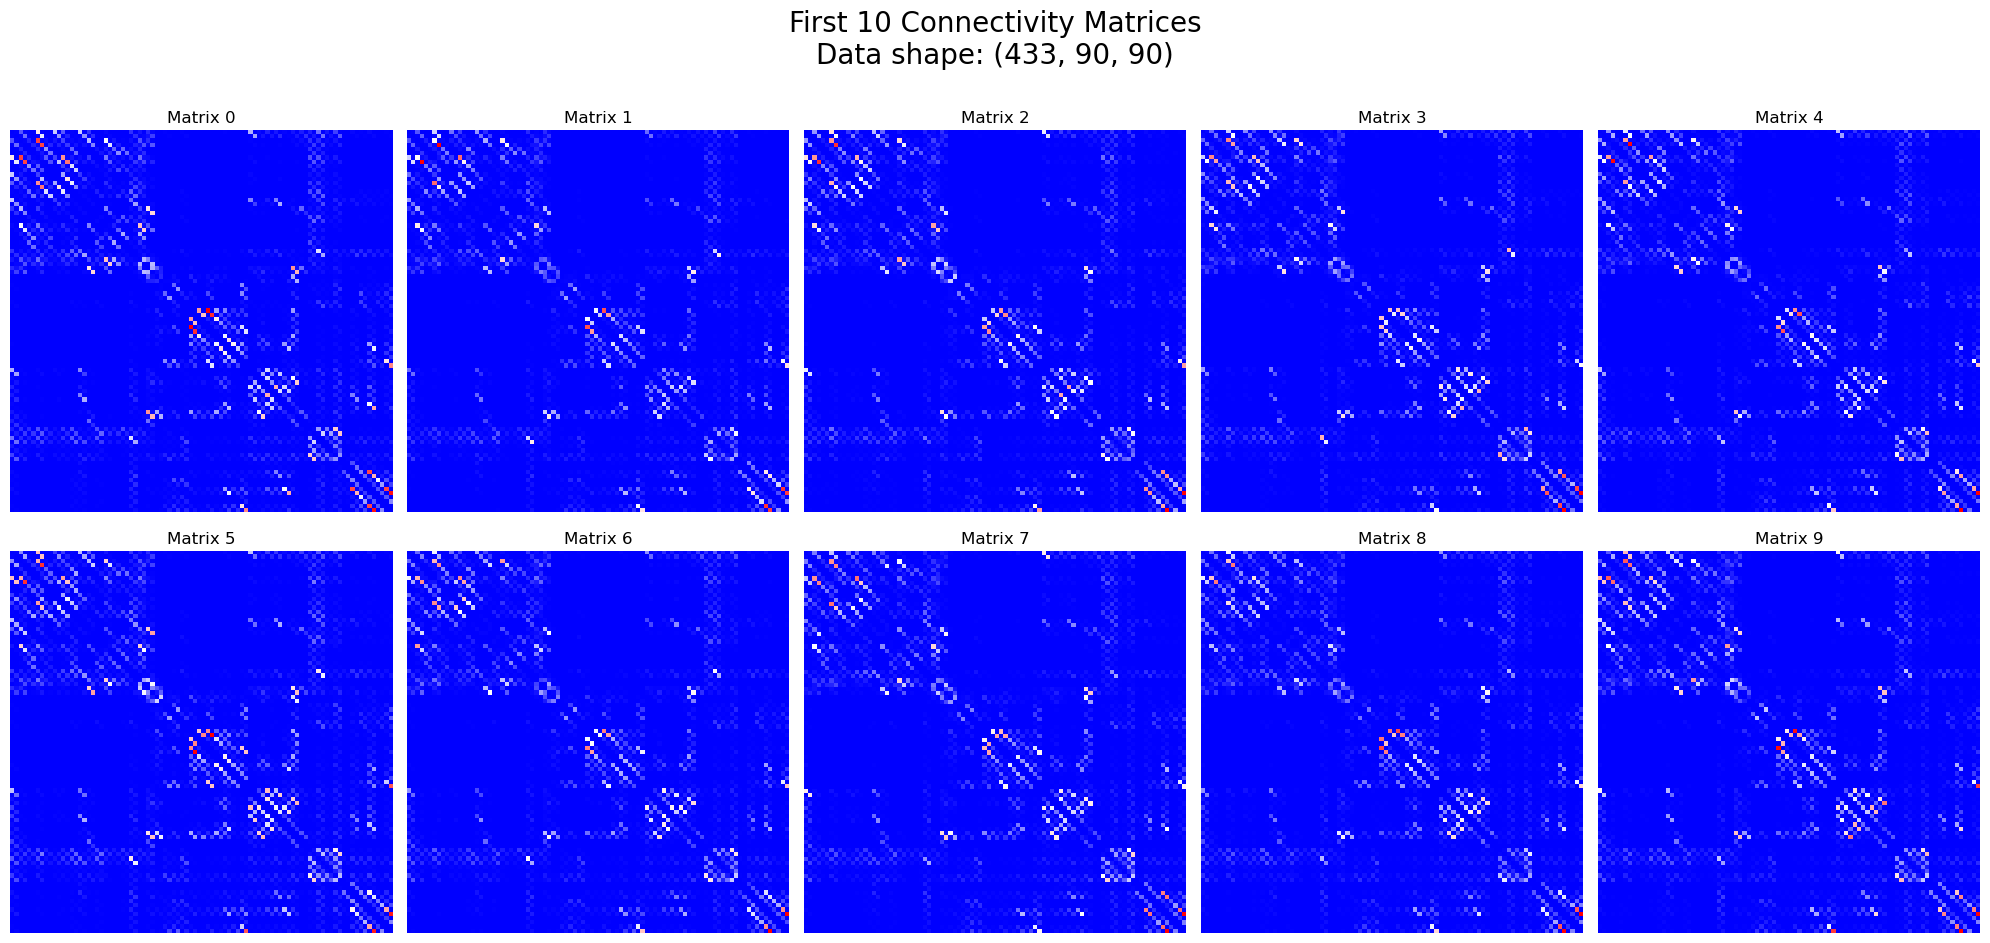

In [3]:
# plot the matrices

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(matrices[i], cmap="bwr")
    ax.axis("off")
    ax.set_title(f"Matrix {i}")
plt.tight_layout()

plt.suptitle(f"First 10 Connectivity Matrices\nData shape: {matrices.shape}", fontsize=20)
plt.subplots_adjust(top=0.9)

plt.show()

In [4]:
n = matrices.shape[0]  # number of matrices
m = matrices.shape[1] # number of rows/columns in each matrix
D = round(m*(m-1)/2) # length of feature vector

print(f"Number of matrices: {n}\nNumber of rows/columns in each matrix: {m}\nLength of feature vector: {D}")

# feature matrix from upper triangular part
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index] = matrices[i,j,k]
            index += 1
print(f"Shape of feature matrix: {X.shape}")

Number of matrices: 433
Number of rows/columns in each matrix: 90
Length of feature vector: 4005
Shape of feature matrix: (433, 4005)


In [5]:
# Read and decrypt the encrypted CSV file
with open("DATA/encrypted_subject_info.csv", "rb") as file:
    encrypted_subject_info = file.read()

decrypted_data = fernet.decrypt(encrypted_subject_info)
subject_info = pd.read_csv(BytesIO(decrypted_data))

subject_info.head()

,age,prematurity
0,41,0
1,41,0
2,40,0
3,41,0
4,41,0


In [6]:
# Convert X into a DataFrame and compare the shapes

X = pd.DataFrame(X)
X.shape, subject_info.shape

((433, 4005), (433, 2))

In [7]:
# Concatenate the two DataFrames
df = pd.concat([subject_info, X], axis=1)
df.shape

(433, 4007)

In [8]:
# Split the data into features and target
X = df.drop('prematurity', axis=1)
y = df['prematurity']


Number of features: 4006
Number of samples: 433


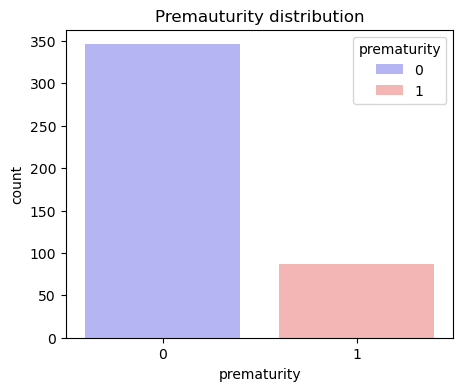

Number of total babies: 433
Number of premature babies: 87
Number of full-term babies: 346
Percentage of premature babies: 20.09%


In [9]:
# Number of features
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# plot
plt.figure(figsize=(5, 4))
sns.countplot(x=y, palette='bwr', hue=y)
plt.title("Premauturity distribution")
plt.show()

print(f"Number of total babies: {len(y)}")
print(f"Number of premature babies: {y.value_counts()[1]}")
print(f"Number of full-term babies: {y.value_counts()[0]}")
print(f"Percentage of premature babies: {round(y.value_counts()[1]/len(y)*100, 2)}%")

There are two challenges when fitting a classifier with this dataset:
1. The dataset is imbalanced. Only 20.9% of the babies are premature.
2. There are more than 4000 features, which is a lot for a dataset with only 433 samples. This can lead to overfitting.

In [10]:
# Train-test split
from sklearn.model_selection import train_test_split

# Ensure all column names are strings
X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Number of training samples: {len(y_train)}")
print(f"Number of test samples: {len(y_test)}")
print(f"Number of premature babies in the training set: {y_train.value_counts()[1]}")
print(f"Number of premature babies in the test set: {y_test.value_counts()[1]}")


Number of training samples: 346
Number of test samples: 87
Number of premature babies in the training set: 70
Number of premature babies in the test set: 17


In [11]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

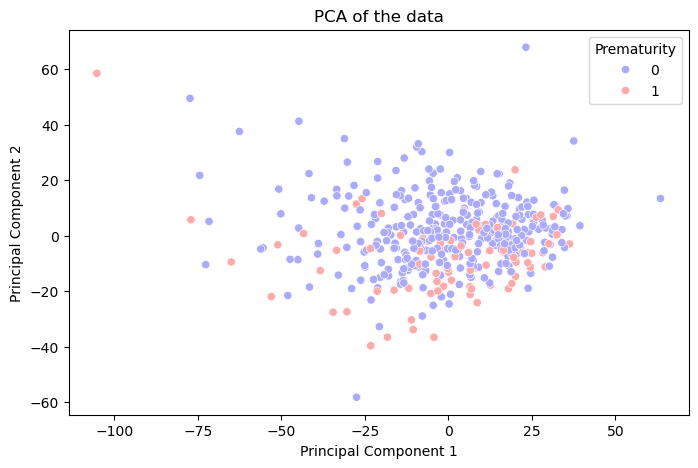

In [12]:
# Visualise the data using PCA
from sklearn.decomposition import PCA

# concatenate the training and test data for PCA
X_all = np.concatenate([X_train_scaled, X_test_scaled], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

# fit PCA
pca = PCA(n_components=2)
X_all_pca = pca.fit_transform(X_all)

# plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_all_pca[:, 0], y=X_all_pca[:, 1], hue=y_all, palette='bwr')
plt.title("PCA of the data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Prematurity")
plt.show()


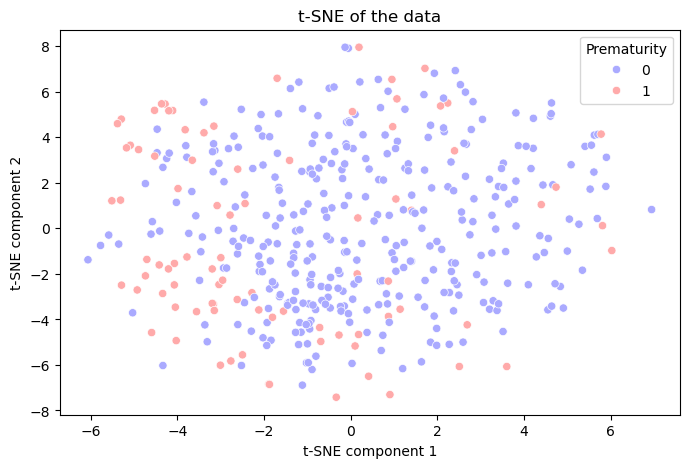

In [13]:
# Visualise the data using t-SNE
from sklearn.manifold import TSNE

# fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_all_tsne = tsne.fit_transform(X_all)

# plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_all_tsne[:, 0], y=X_all_tsne[:, 1], hue=y_all, palette='bwr')
plt.title("t-SNE of the data")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend(title="Prematurity")
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


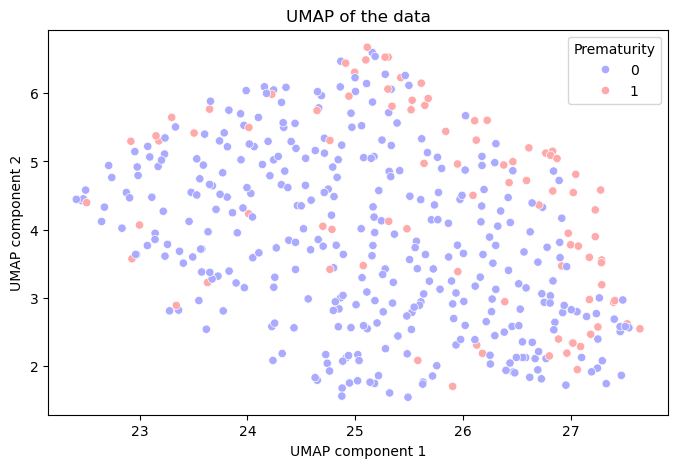

In [14]:
# Visualise the data using UMAP
import umap.umap_ as umap

# fit UMAP
umap_model = umap.UMAP()
X_all_umap = umap_model.fit_transform(X_all)

# plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_all_umap[:, 0], y=X_all_umap[:, 1], hue=y_all, palette='bwr')
plt.title("UMAP of the data")
plt.xlabel("UMAP component 1")
plt.ylabel("UMAP component 2")
plt.legend(title="Prematurity")
plt.show()


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluation(model, X_test, y_test):
        print(f"Test accuracy: {round(accuracy_score(y_test, model.predict(X_test)), 2)}")
        print(f"Test precision: {round(precision_score(y_test, model.predict(X_test)), 2)}")
        print(f"Test recall/sensitivity: {round(recall_score(y_test, model.predict(X_test)), 2)}")
        print(f"Test specificity: {round(recall_score(y_test, model.predict(X_test), pos_label=0), 2)}")
        print(f"Test f1 score: {round(f1_score(y_test, model.predict(X_test)), 2)}")


In [16]:
# Fit logistic regression classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create Logistic Regression model with balanced class weight
model = LogisticRegression(class_weight='balanced', max_iter=1000)
param = {'C': np.logspace(-3, 3, 13)}

# Perform cross-validated grid search to tune the 'C' parameter
grid_search = GridSearchCV(model, param, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model from the cross-validation grid search
model_1 = grid_search.best_estimator_

# Print cross-validation results
print("Cross-Validated F1 Score (average over folds):", round(grid_search.best_score_, 2))
print("Best parameters found:", grid_search.best_params_)

Cross-Validated F1 Score (average over folds): 0.8
Best parameters found: {'C': 1.0}


In [17]:
# Train vs Test evaluation

print("Training set evaluation:")
evaluation(model_1, X_train, y_train)
print("\nTest set evaluation:")
evaluation(model_1, X_test, y_test)

Training set evaluation:
Test accuracy: 1.0
Test precision: 1.0
Test recall/sensitivity: 1.0
Test specificity: 1.0
Test f1 score: 1.0

Test set evaluation:
Test accuracy: 0.89
Test precision: 0.73
Test recall/sensitivity: 0.65
Test specificity: 0.94
Test f1 score: 0.69


In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('pca', PCA()), ('lr', LogisticRegression(class_weight='balanced', max_iter=10000, solver='saga'))])
param_grid = {
    'pca__n_components': [2, 5, 10, 20, 50, 100],
    'lr__C': np.logspace(-3, 3, 13)
}

optimised_grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5))
optimised_grid_search.fit(X_train, y_train)

model_2 = optimised_grid_search.best_estimator_

# Print cross-validation results
print("Cross-Validated F1 Score (average over folds):", round(optimised_grid_search.best_score_, 2))
print("Best parameters found:", optimised_grid_search.best_params_)

Cross-Validated F1 Score (average over folds): 0.62
Best parameters found: {'lr__C': 0.03162277660168379, 'pca__n_components': 50}


In [19]:
# Train vs Test evaluation

print("Training set evaluation:")
evaluation(model_2, X_train, y_train)

print("\nTest set evaluation:")
evaluation(model_2, X_test, y_test)

Training set evaluation:
Test accuracy: 0.8
Test precision: 0.51
Test recall/sensitivity: 1.0
Test specificity: 0.75
Test f1 score: 0.67

Test set evaluation:
Test accuracy: 0.78
Test precision: 0.47
Test recall/sensitivity: 0.88
Test specificity: 0.76
Test f1 score: 0.61


In [38]:
# Save both models
pickle.dump(model_1, open("DATA/model_1_lr.p", "wb"))
pickle.dump(model_2, open("DATA/model_2_lr_with_pca.p", "wb"))

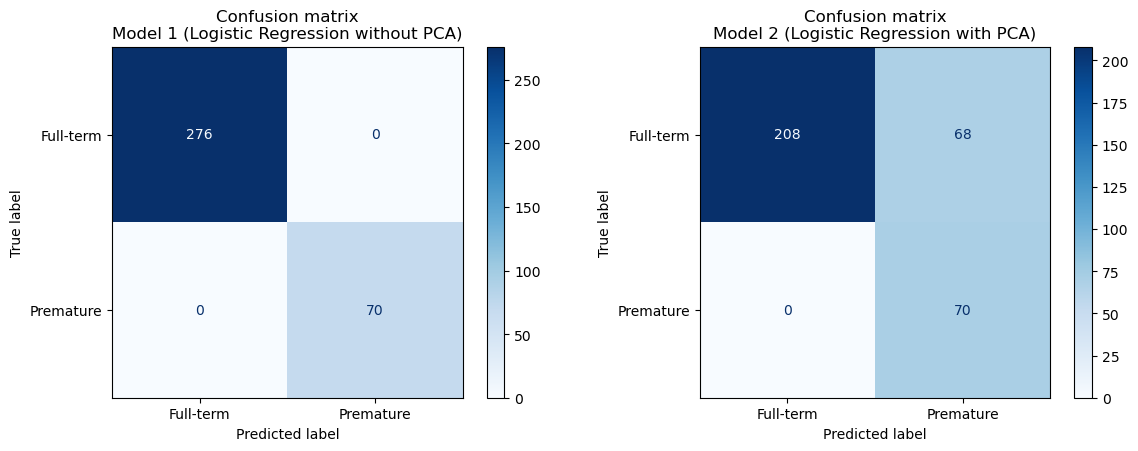

In [ ]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

cm = confusion_matrix(y_train, model_1.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Full-term', 'Premature'])
disp.plot(cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion matrix\nModel 1 (Logistic Regression without PCA)")

cm = confusion_matrix(y_train, model_2.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Full-term', 'Premature'])
disp.plot(cmap='Blues', ax=axs[1])
axs[1].set_title("Confusion matrix\nModel 2 (Logistic Regression with PCA)")

plt.tight_layout()
# adjust title not to overlpa with color bar
plt.subplots_adjust(top=0.9)
plt.show()



## Model Comparison and Analysis

### Model 1 Performance Analysis
- **Training Evaluatioin**: shows perfect performance on the training set. A clear sign of overfitting.
- **Validation Evaluation**: all metrics drop significantly. The model is not generalizing well.

### Model 2 Performance Analysis
- **Training Evaluatioin**: Performs less on training data (accuracy of 0.8 and F1 score of 0.67). Lower than Model 1, but suggests a realistc fit.
- **Validation Evaluation**: More balanced metrics. Shows smaller drop between training and validation metrics (accuracy of 0.78 and F1 score of 0.61). The recall (0.88) remains high, indicating that the model is effective at detecting the minority class, which is critical for handling the imbalance. However, precision (0.47) is slightly lower, suggesting some false positives, which may be a reasonable trade-off for higher recall.

### Model 2 Approach:
To counter overfitting, Model 2 integrates **Principal Component Analysis (PCA)** for dimensionality reduction before applying **Logistic Regression**. This approach introduces a couple of advantages:
1. **Dimensionality Reduction with PCA**: Uses PCA to reduce number of features from 4000+ to 50. This helps prevent overfitting and improves model generalization.
2. **Logistic Regression with ‘balanced’ Class Weights**: Similar to Model 1, Model 2 also applies `class_weight='balanced'`. This adjustment improves the model’s ability to handle the imbalanced data.
3. **Hyperparameter Tuning**: The GridSearchCV evaluates different `C` values (regularization) for logistic regression and several `n_components` values for PCA. Tuning these parameters helps optimize the balance between underfitting and overfitting.
4. **Logistic Regression with 'saga' Solver**: The 'saga' solver is used for logistic regression, which is suitable for large datasets.

### Reccomendation:
Model 2 appears to be the better option due to its improved generalizability and balanced performance across metrics, which is key in scenarios with imbalanced data.